***Code to calculate the before and after registration metrics on all tissues and plot box plots***

Last edited on 12/04/2024

The metrics csv file stored at: /nfs2/forGaurav/yesbackup/DAPI_reg/final_metrics

In [1]:
from PIL import Image
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from my_utils import Utils
import glob
import re
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
from my_utils import Utils
import torch
import csv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

/tmp/ipykernel_775992/276627886.py:16: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
Image.MAX_IMAGE_PIXELS = None
def extract_round_number(filename):
    match = re.search(r'_ROUND_(\d+)_', filename)
    if match:
        return int(match.group(1))
    else:
        return 0
#Step 1: Load the images and apply the masks
tissue_names_file='/nfs2/baos1/rudravg/tissue_names.txt'
original_tissues_path='/nfs2/baos1/rudravg'

raw_dir='/home-local/rudravg/Segmentation_test/Images'
mask_dir='/home-local/rudravg/Segmentation_test/Masks'
model_path='/home-local/rudravg/test_DAPI/epochs/epoch_50/epoch_50.pth'

#Reading all tissue names
with open(tissue_names_file, 'r') as file:
    tissue_names = [line.strip() for line in file.readlines()]

In [3]:
with open('/nfs2/forGaurav/yesbackup/DAPI_reg/final_metricsoutput_version2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['tissue', 'round_x', 'before_ncc', 'after_ncc','intensity'])
    for tissue in tqdm(tissue_names,desc='Generating Images and Truths'):
        search_pattern_raw_files = os.path.join(original_tissues_path, tissue + '*')
        matching_files_raw = glob.glob(search_pattern_raw_files)
        sorted_files_raw = sorted(matching_files_raw, key=extract_round_number) #This is important
        mask_search_pattern = os.path.join(original_tissues_path, 'Retention_Masks', tissue + '*')
        mask_files = glob.glob(mask_search_pattern)
        round_0=sorted_files_raw[0]
        if mask_files:
            mask_name = mask_files[0]
            mask=np.array(Image.open(mask_name))
            mask = (mask > 0).astype(int)
        else:
            print(f"Bruh fix mask for {tissue}")
            continue
        for round_x in sorted_files_raw[1:]:
            moving,fixed,orig_height,orig_width=Utils.load_images_and_apply_mask(round_0,round_x,mask_name)
            model,device=Utils.load_model(model_path)
            registered_tissue,L2_warp=Utils.register_tissues(moving,fixed,model,device)
            moving_unpadded=moving[:orig_height,:orig_width]
            fixed_unpadded=fixed[:orig_height,:orig_width]
            registered_tissue_unpadded=registered_tissue[:orig_height,:orig_width]
            L2_warp=L2_warp[:orig_height,:orig_width]
            intensity_corrected_tissue,intensity_factor=Utils.adjust_intensity(fixed_unpadded,registered_tissue_unpadded)
            before_ncc=Utils.calculate_ncc(fixed_unpadded.ravel(),moving_unpadded.ravel())
            after_ncc=Utils.calculate_ncc(fixed_unpadded.ravel(),registered_tissue_unpadded.ravel())
            writer.writerow([tissue, round_x, before_ncc, after_ncc,intensity_factor])

Generating Images and Truths:   0%|          | 0/62 [00:00<?, ?it/s]/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils.py:20: RuntimeWarning: divide by zero encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)
/nfs2/forGaurav/yesbackup/DAPI_RegSegNet/vxl_morph/voxelmorph-dev/my_utils.py:20: RuntimeWarning: invalid value encountered in divide
  ratio = np.where(target_image != 0, original_image / target_image, 0)


***Box Plots yaaay***

In [ ]:
metrics='/nfs2/forGaurav/yesbackup/DAPI_reg/final_metricsoutput.csv'
data_loaded = pd.read_csv(metrics)
data_loaded['before_ncc'] = data_loaded['before_ncc'].str.strip('[]').astype(float)
data_loaded['after_ncc'] = data_loaded['after_ncc'].str.strip('[]').astype(float)



In [ ]:
unique_tissues = data_loaded['tissue'].unique()
tissue_to_number = {tissue: i+1 for i, tissue in enumerate(unique_tissues)}
data_loaded['tissue_number'] = data_loaded['tissue'].map(tissue_to_number)

# Preparing data for plotting by melting the DataFrame
data_melted = data_loaded.melt(id_vars=['tissue_number'], value_vars=['before_ncc', 'after_ncc'], 
                               var_name='Condition', value_name='NCC Value')



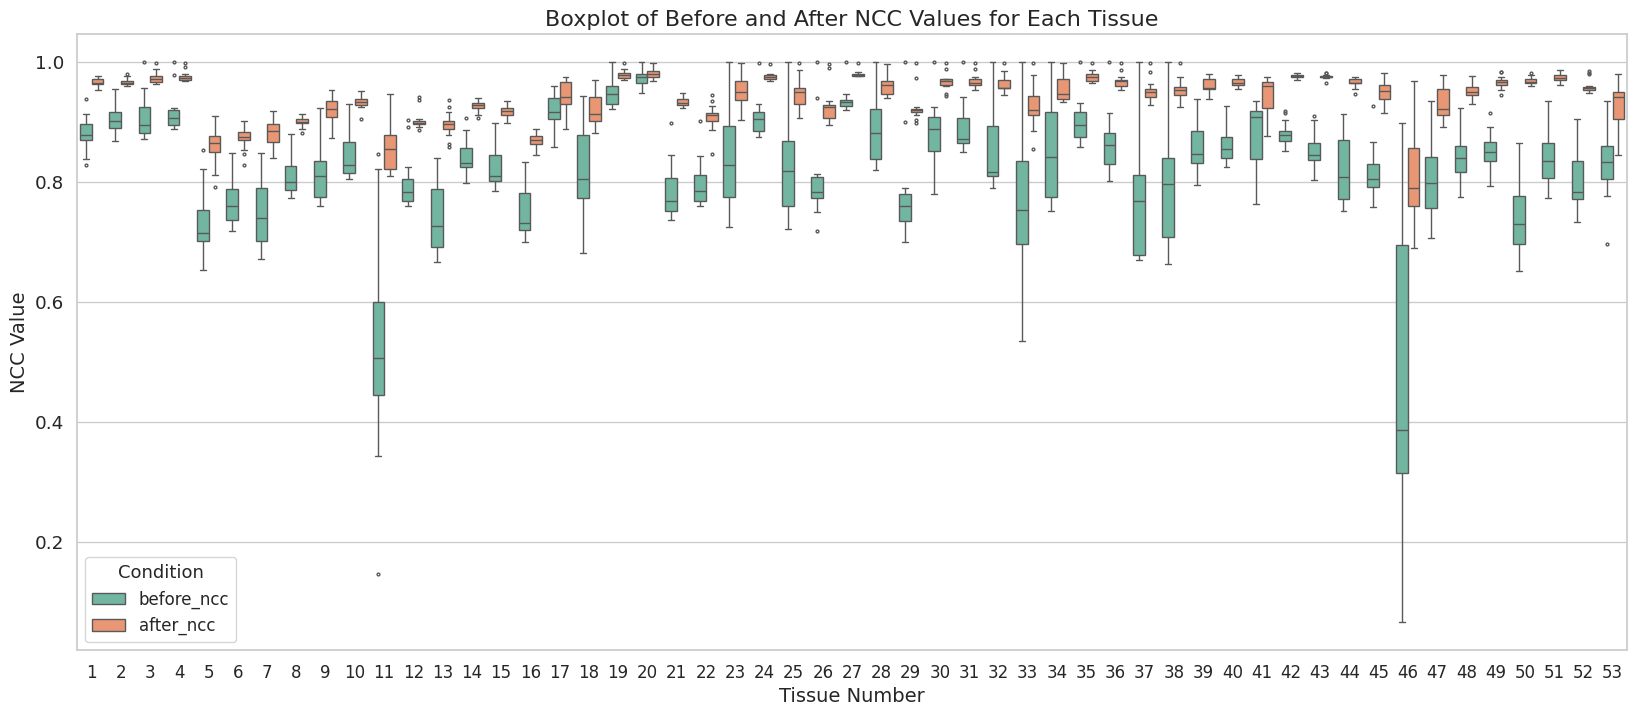

In [ ]:
# Set the theme and context
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the figure and the boxplot
plt.figure(figsize=(20, 8))
ax = sns.boxplot(x='tissue_number', y='NCC Value', hue='Condition', data=data_melted, palette='Set2', dodge=True, fliersize=2)

# Set the title, labels, and legend
ax.set_title('Boxplot of Before and After NCC Values for Each Tissue', fontsize=16)
ax.set_xlabel('Tissue Number', fontsize=14)
ax.set_ylabel('NCC Value', fontsize=14)
plt.legend(title='Condition', title_fontsize='13', fontsize='12')

# Set the x-ticks
plt.xticks(ticks=range(len(unique_tissues)), labels=[f'{i+1}' for i in range(len(unique_tissues))], fontsize=12)

plt.show()

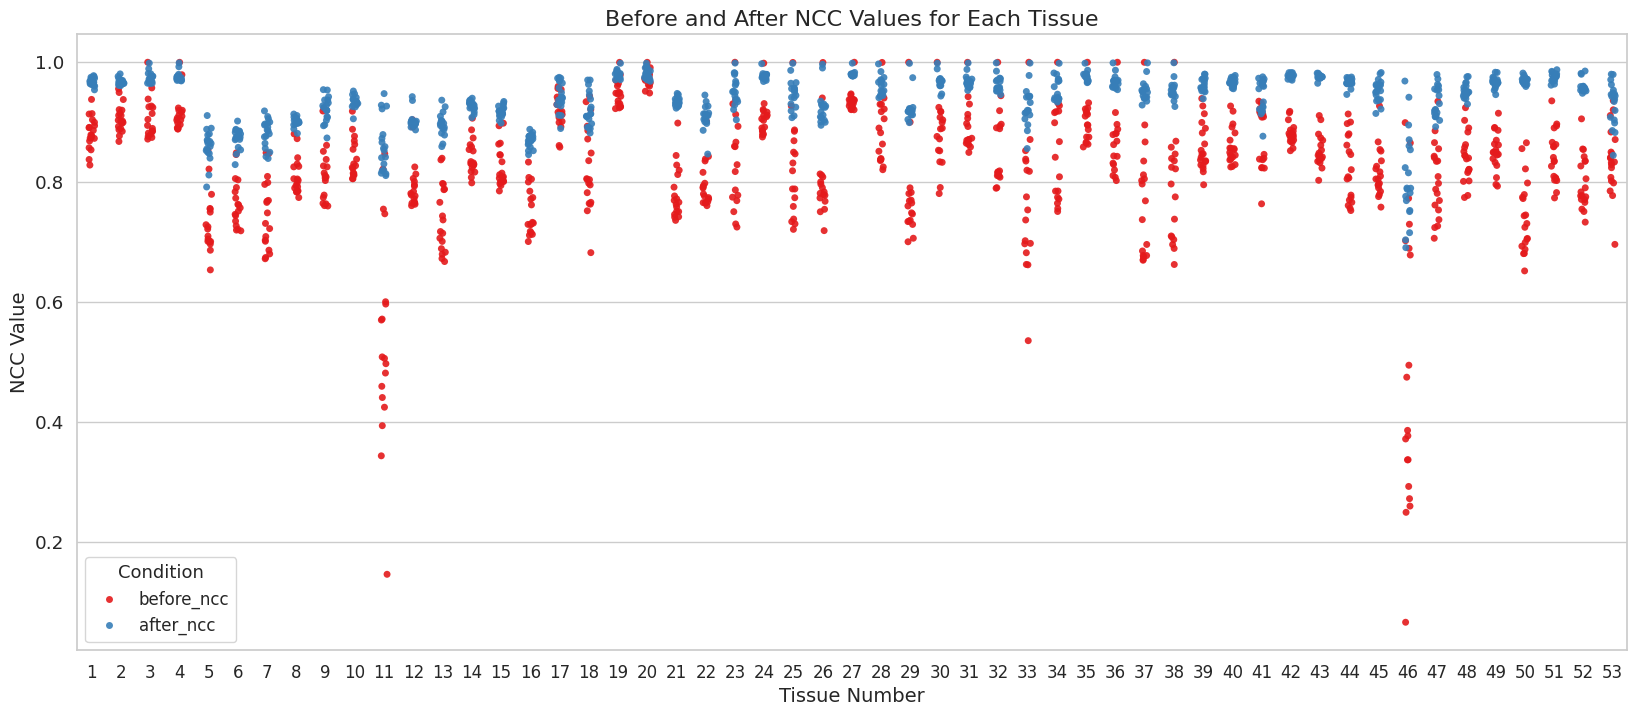

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the figure and the stripplot
plt.figure(figsize=(20, 8))
ax = sns.stripplot(x='tissue_number', y='NCC Value', hue='Condition', data=data_melted, palette='Set1', jitter=True, size=5,alpha=0.9)

# Set the title, labels, and legend
ax.set_title('Before and After NCC Values for Each Tissue', fontsize=16)
ax.set_xlabel('Tissue Number', fontsize=14)
ax.set_ylabel('NCC Value', fontsize=14)
plt.legend(title='Condition', title_fontsize='13', fontsize='12')

# Set the x-ticks
plt.xticks(ticks=range(len(unique_tissues)), labels=[f'{i+1}' for i in range(len(unique_tissues))], fontsize=12)

plt.show()

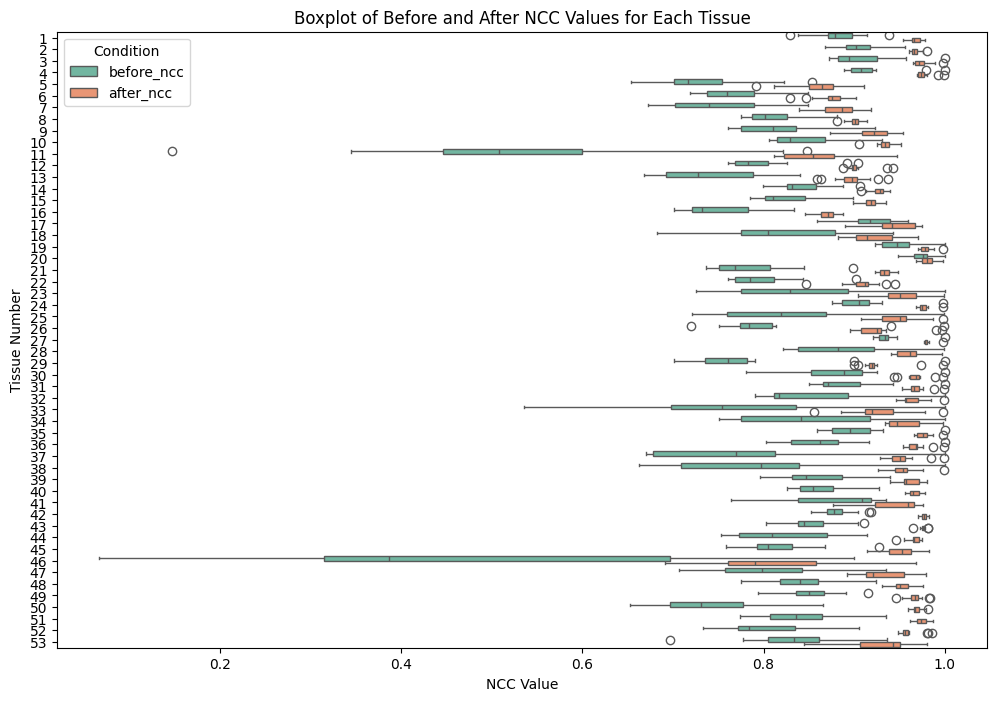

In [ ]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(y='tissue_number', x='NCC Value', hue='Condition', data=data_melted, palette='Set2', dodge=True, orient='h')
ax.set_title('Boxplot of Before and After NCC Values for Each Tissue')
plt.legend(title='Condition')
ax.set_ylabel('Tissue Number')
plt.yticks(ticks=range(len(unique_tissues)), labels=[f'{i+1}' for i in range(len(unique_tissues))])
plt.show()